Starting ECG import..


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 1897.92it/s]


Finished!
Starting ECG import..


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 1334.42it/s]


Finished!


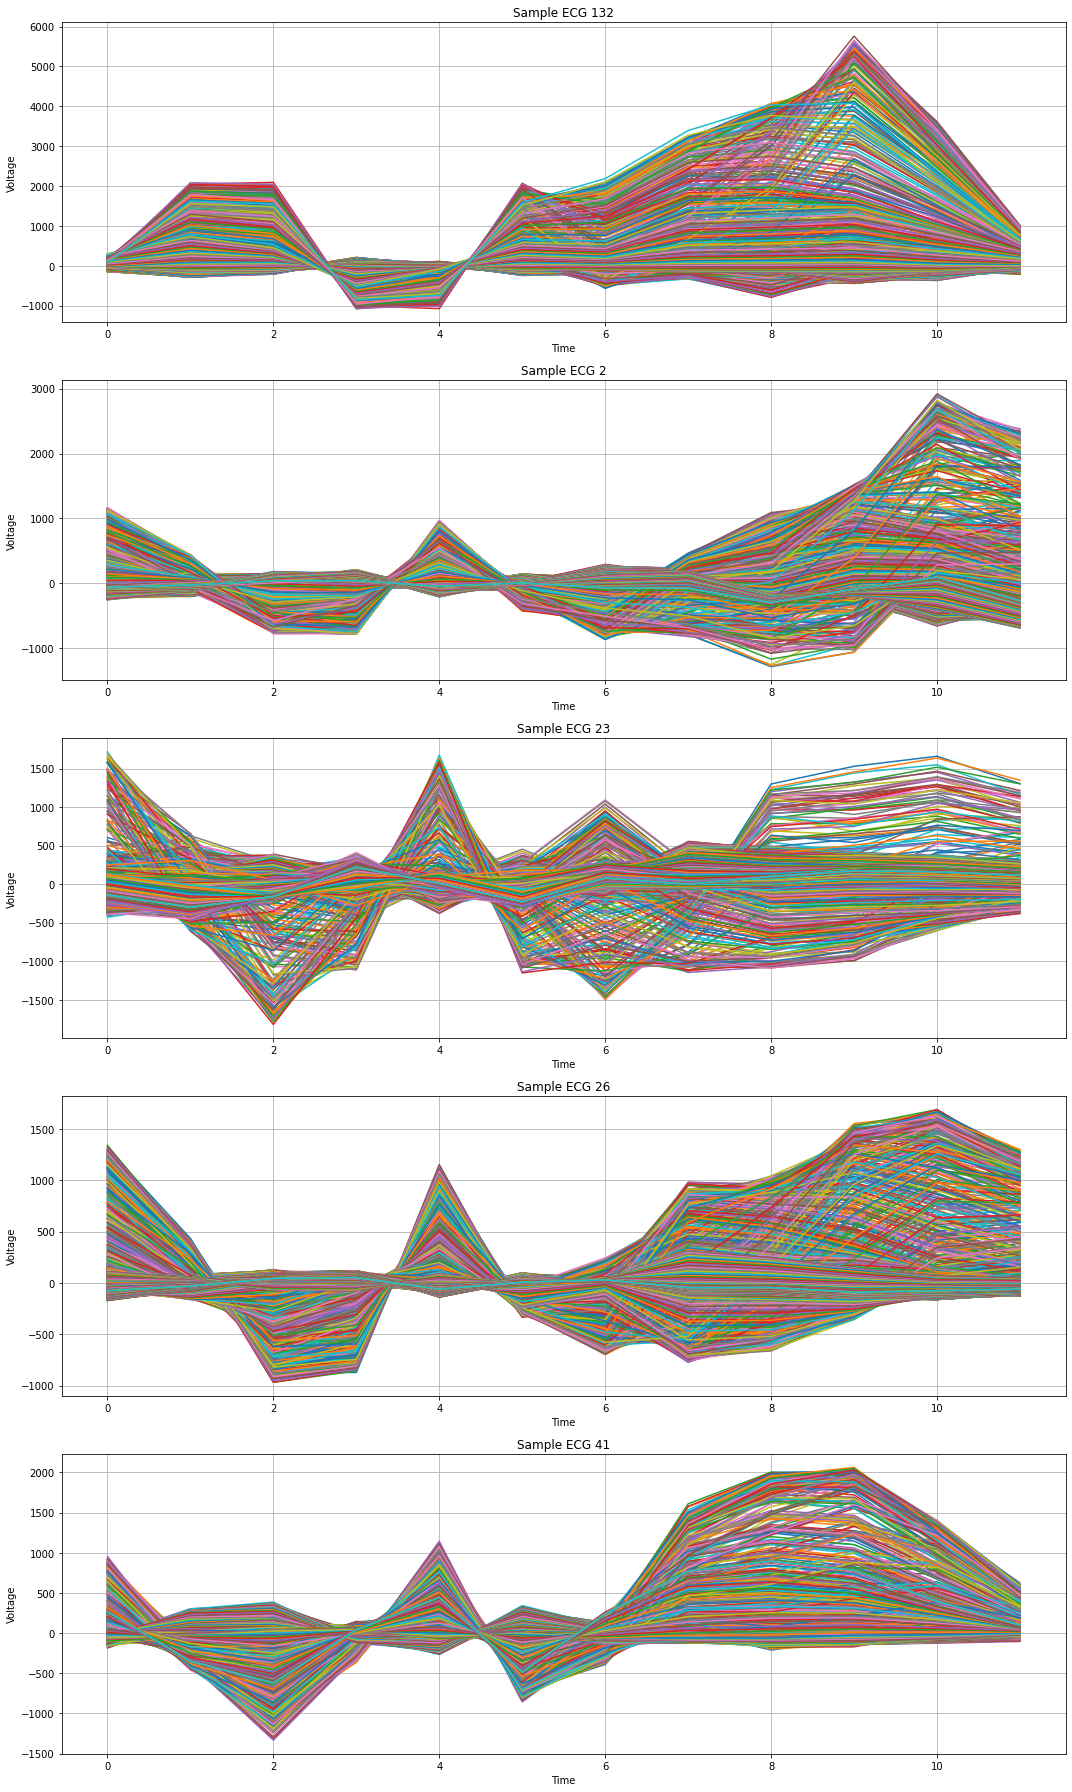

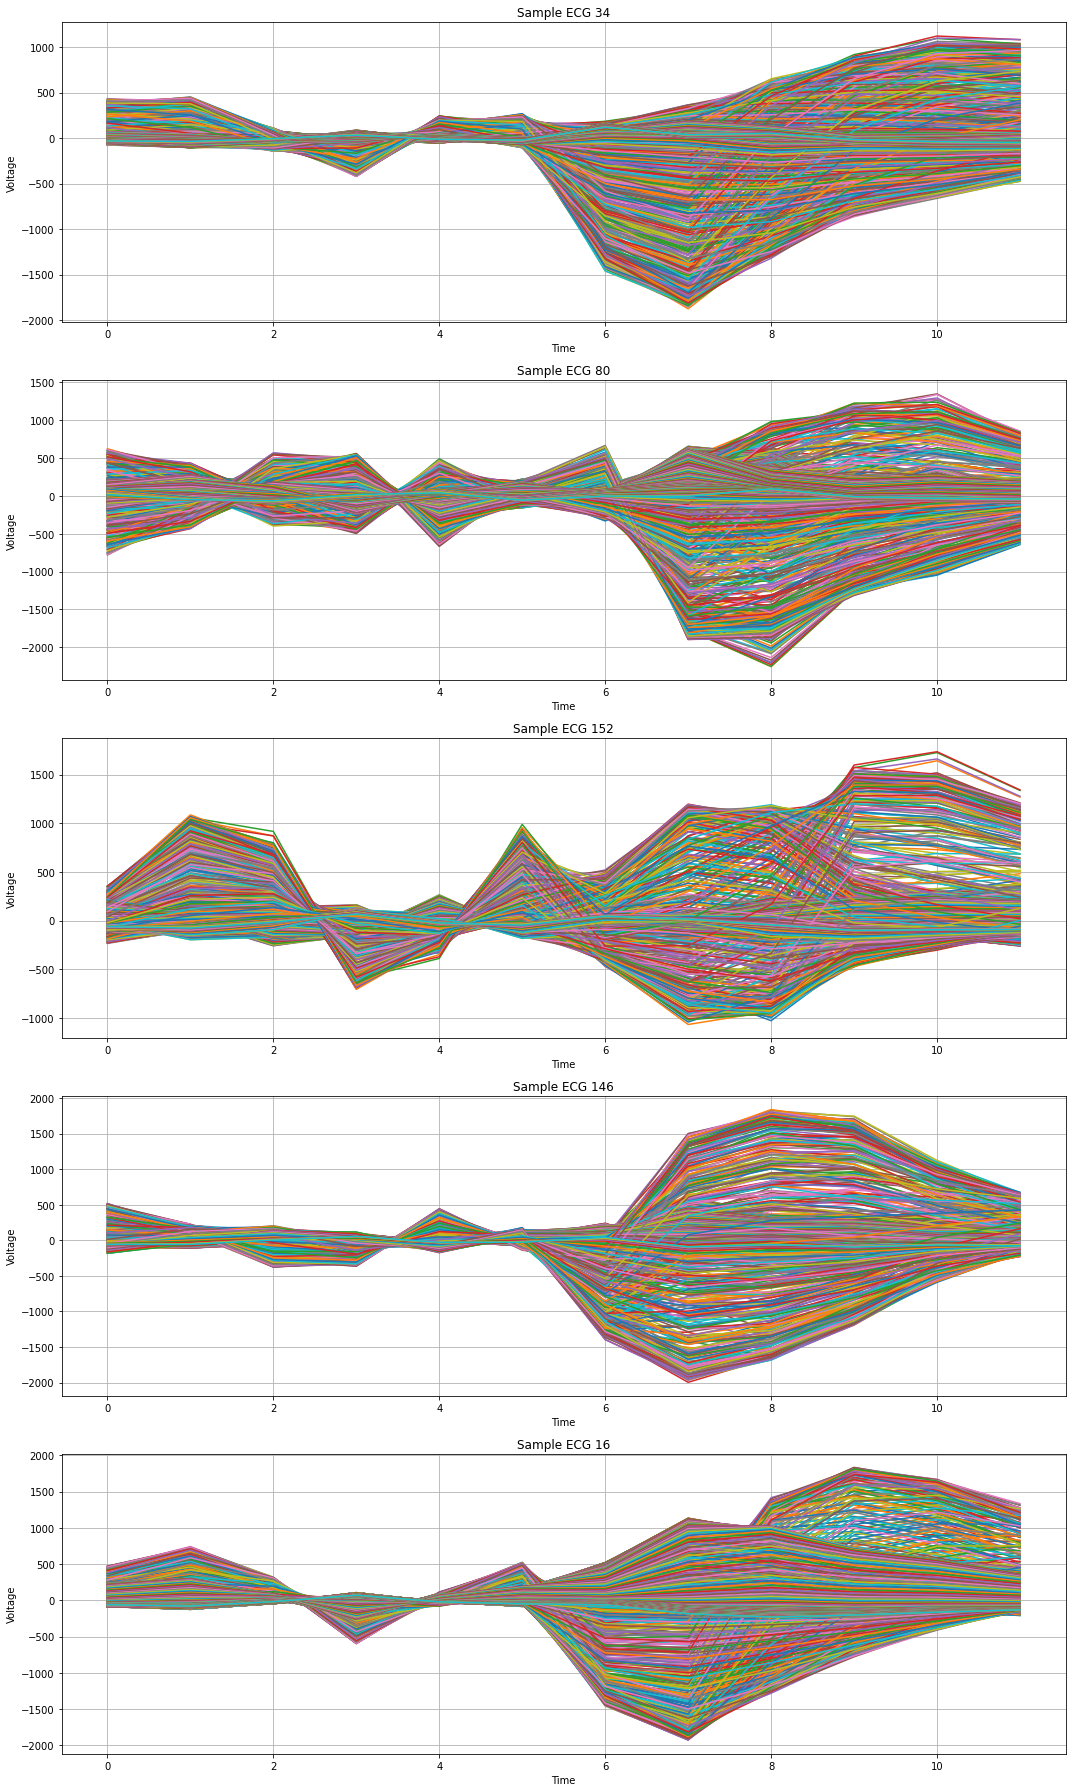

100%|█████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 80120.42it/s]


In [12]:
#library imports
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from keras.utils import pad_sequences
import neurokit2 as nk
normal_sinus_dir = "C:/Users/NEHAL NAGPAL/Desktop/dataset/normal"
wpw_dir = "C:/Users/NEHAL NAGPAL/Desktop/dataset/wpw"
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data
def import_ecg_data(directory, ecg_len = 5000, trunc="post", pad="post"):
    print("Starting ECG import..")
    ecgs = []
    for ecgfilename in tqdm(sorted(os.listdir(directory))):
        filepath = directory + os.sep + ecgfilename
        if filepath.endswith(".mat"):
            data, header_data = load_challenge_data(filepath)
            data = pad_sequences(data, maxlen=ecg_len, truncating=trunc,padding=pad)
            ecgs.append(data)
    print("Finished!")
    return np.asarray(ecgs)
normal_sinus = import_ecg_data(normal_sinus_dir)
wpw = import_ecg_data(wpw_dir)
num_samples = 5
sample_indices = np.random.choice(len(wpw), num_samples, replace=False)
plt.figure(figsize=(15, 5*num_samples))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples, 1, i+1)
    plt.plot(wpw[idx])
    plt.title(f"Sample ECG {idx}")
    plt.xlabel("Time")
    plt.ylabel("Voltage")
    plt.grid(True)
plt.tight_layout()
plt.show()
num_samples = 5
sample_indices = np.random.choice(len(normal_sinus), num_samples, replace=False)
plt.figure(figsize=(15, 5*num_samples))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples, 1, i+1)
    plt.plot(normal_sinus[idx])
    plt.title(f"Sample ECG {idx}")
    plt.xlabel("Time")
    plt.ylabel("Voltage")
    plt.grid(True)
plt.tight_layout()
plt.show()

def resample_beats(beats):
    rsmp_beats=[]
    for i in beats:
        i = np.asarray(i)
        f = signal.resample(i, 250)
        rsmp_beats.append(f)
    rsmp_beats = np.asarray(rsmp_beats)
    return rsmp_beats
def median_beat(beat_dict):
    beats = []
    for i in beat_dict.values():
        beats.append(i['Signal'])
    beats = np.asarray(beats)
    rsmp_beats = resample_beats(beats)
    med_beat = np.median(rsmp_beats,axis=0)
    return med_beat
def remove_nans(ecg_arr):
    new_arr = []
    for i in tqdm(ecg_arr):
        twelve_lead = []
        for j in i:
            if j[0] != j[0]:
                j = np.ones(250)
            twelve_lead.append(j)
        new_arr.append(twelve_lead)
    new_arr = np.asarray(new_arr)
    return new_arr
new_norm = remove_nans(normal_sinus)
new_wpw = remove_nans(wpw)
def remove_some_ecgs(ecg_arr):
    delete_list = []
    for i in tqdm(range(len(ecg_arr))):
        if np.all(ecg_arr[i].T[0]==1):
            delete_list.append(i)
    ecg_arr = np.delete(ecg_arr,delete_list,axis=0)
    return ecg_arr
clean_wpw = remove_some_ecgs(new_wpw)
clean_norm = remove_some_ecgs(new_norm)
clean_wpw = np.moveaxis(clean_wpw, 1, -1)
clean_norm = np.moveaxis(clean_norm, 1, -1)
norm_train = clean_norm[:-30]
norm_val = clean_norm[-30:]
wpw_train = clean_wpw[:50]
wpw_val = clean_wpw[50:]
y_norm_train = np.zeros(norm_train.shape[0])
y_norm_val = np.zeros(norm_val.shape[0])
y_wpw_train = np.ones(wpw_train.shape[0])
y_wpw_val = np.ones(wpw_val.shape[0])
X_train = np.vstack([norm_train,wpw_train])
y_train = np.hstack([y_norm_train,y_wpw_train])
X_val = np.vstack([norm_val,wpw_val])
y_val = np.hstack([y_norm_val,y_wpw_val])

In [32]:
from keras.layers import Input, Conv1D, MaxPooling1D, concatenate, AveragePooling1D, Dropout, Dense, Flatten, BatchNormalization
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, concatenate
def InceptionModule(previous_layer, filters):
    # 1x1 convolution
    conv1x1 = Conv1D(filters[0], kernel_size=1, activation='relu', padding='same')(previous_layer)
    # 3x3 convolution
    conv3x3 = Conv1D(filters[1], kernel_size=1, activation='relu', padding='same')(previous_layer)
    conv3x3 = Conv1D(filters[1], kernel_size=3, activation='relu', padding='same')(conv3x3)
    # 5x5 convolution
    conv5x5 = Conv1D(filters[2], kernel_size=1, activation='relu', padding='same')(previous_layer)
    conv5x5 = Conv1D(filters[2], kernel_size=5, activation='relu', padding='same')(conv5x5)
    # Max pooling
    max_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(previous_layer)
    max_pool = Conv1D(filters[3], kernel_size=1, activation='relu', padding='same')(max_pool)
    # Concatenate the outputs along the channel axis
    concatenated = concatenate([conv1x1, conv3x3, conv5x5, max_pool], axis=-1)
    return concatenated
def GoogleNet(input_shape):
    input_layer = Input(shape=input_shape) 
    conv1 = Conv1D(64, kernel_size=7, activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling1D(pool_size=3, strides=2, padding='same')(conv1)
    norm1 = BatchNormalization()(pool1)
    inception1a = InceptionModule(norm1, filters=(64, 96, 128, 16, 32))
    inception1b = InceptionModule(inception1a, filters=(128, 128, 192, 32, 96))
    pool2 = MaxPooling1D(pool_size=3, strides=2, padding='same')(inception1b)
    inception2a = InceptionModule(pool2, filters=(192, 96, 208, 16, 48))
    inception2b = InceptionModule(inception2a, filters=(160, 112, 224, 24, 64))
    inception2c = InceptionModule(inception2b, filters=(128, 128, 256, 24, 64))
    inception2d = InceptionModule(inception2c, filters=(112, 144, 288, 32, 64))
    inception2e = InceptionModule(inception2d, filters=(256, 160, 320, 32, 128))
    pool3 = MaxPooling1D(pool_size=3, strides=2, padding='same')(inception2e)
    flatten = Flatten()(pool3)
    dense1 = Dense(1024, activation='relu')(flatten)
    dropout1 = Dropout(0.4)(dense1)
    output_layer = Dense(1, activation='sigmoid')(dropout1)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model
input_shape = (5000, 12)
model = GoogleNet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)
model.save('wpw_googlenet_model.h5')

Epoch 1/10
6/6 [==============================] - 161s 25s/step - loss: 24.8533 - accuracy: 0.4667 - val_loss: 0.7467 - val_accuracy: 0.3571
Epoch 2/10
6/6 [==============================] - 184s 31s/step - loss: 0.6523 - accuracy: 0.7222 - val_loss: 3.9114 - val_accuracy: 0.2143
Epoch 3/10
6/6 [==============================] - 154s 24s/step - loss: 0.5903 - accuracy: 0.7222 - val_loss: 42.8892 - val_accuracy: 0.2143
Epoch 4/10
6/6 [==============================] - 169s 28s/step - loss: 1.4160 - accuracy: 0.7333 - val_loss: 2.2166 - val_accuracy: 0.2143
Epoch 5/10
6/6 [==============================] - 194s 28s/step - loss: 0.5929 - accuracy: 0.7500 - val_loss: 0.8217 - val_accuracy: 0.3571
Epoch 6/10
6/6 [==============================] - 159s 26s/step - loss: 0.4884 - accuracy: 0.7444 - val_loss: 1.0322 - val_accuracy: 0.5000
Epoch 7/10
6/6 [==============================] - 202s 33s/step - loss: 0.4164 - accuracy: 0.8389 - val_loss: 0.6034 - val_accuracy: 0.7786
Epoch 8/10
6/6 [==

In [33]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)

5/5 [==============================] - 13s 2s/step - loss: 5.0496 - accuracy: 0.4857
Validation accuracy: 0.48571428656578064
